# Predicting strokes

## Introduction

Strokes occur when the supply of blood to the brain is reduced or blocked completely, which prevents brain tissue from getting oxygen and nutrients. This causes brain tissue damage, thus reduction in brain function. https://www.healthdirect.gov.au/stroke <br>
A stroke can cause permanent loss of function. The long-term effects of stroke depend on which part of the brain was damaged and by how much. Early treatment and rehabilitation after stroke can improve recovery and many people regain a lot of function. Ideally, **early detection and prevention is more preferred than treatment and rehab**. <br>
The most recent data for Australia shows that after a stroke, slightly more than one third of people have a disability that has affected their daily activities. Of the people with a disability after stroke, 88 per cent are cared for in households and 12 per cent in residential care. https://www.betterhealth.vic.gov.au/health/conditionsandtreatments/effects-of-stroke <br>
Strokes negatively impact the following:
- Physical performance
- Emotional and psychological characteristics
- Thinking, memory and perception
- Communication
- Financial impact on carers and family

## Aim

The aim of this project is to create a predictive model that can be applied at a GP level, using medical history and basic GP examinations, to determine whether a patient has a likelihood for developing a stroke or not. This will be the first step towards diagnosing stroke. Doctors can use the outcome of the model to recommend CT scans, MRIs, further blood tests, etc... for more in-depth diagnosis of stroke.

### 1.1  Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.datasets import make_blobs
from scipy import stats
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import validation_curve
from sklearn.preprocessing import StandardScaler

%matplotlib inline

### 1.2 Importing data

In [2]:
stroke_csv = r'C:\Users\matta\Downloads\Data\healthcare-dataset-stroke-data.csv'
stroke = pd.read_csv(stroke_csv)

In [3]:
stroke.head(4)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1


## 2: EDA

In [4]:
stroke.shape

(5110, 12)

In [5]:
stroke.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


**Column headings**:

#### Classification scores after SMOTE

| Model | Recall score | 
|:--------------|:-----------|
| **id** | Unique identifier. Integer.   |
| **gender**      | "Male", "Female" or "Other". Category. |   
| **age**      | age of the patient. Integer.|
| **hypertension**      | 0 if the patient doesn't have hypertension, 1 if the patient has hypertension. Boolean.|
| **heart_disease** |  0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease. Boolean. |
| **ever_married**      |"No" or "Yes". Category.|   
| **work_type**      | "children", "Govt_jov", "Never_worked", "Private" or "Self-employed". Category.|
| **Residence_type**      | "Rural" or "Urban". Category.|
| **avg_glucose_level** | average glucose level in blood. float. |
| **bmi**      |body mass index. float.|   
| **smoking_status**      | "formerly smoked", "never smoked", "smokes" or "Unknown". category|
| **stroke**      | 1 if the patient had a stroke or 0 if not. Boolean|


**Notes**:
- Use LogReg when classifying using continuous data. Can also be used to multiclass.
- Use SVM when classifying using categorical data?? can also use continuous data.
- Use GaussianNB when classifying using continuous data. Can be good with multiclass
- Use BernoulliNB when classifying using binary data
- Use MultinomialNB when classifying using other categorical data

In [6]:
stroke['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [7]:
249/4861

0.051224027977782347

**Very important note**: The models need to have an accuracy higher than 5% for true positives and 95% for true negatives.

### 2.1: Correlation

In [8]:
corr = stroke.corr()
corr

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
id,1.000000,0.003538,0.003550,-0.001296,0.001092,0.003084,0.006388
age,0.003538,1.000000,0.276398,0.263796,0.238171,0.333398,0.245257
hypertension,0.003550,0.276398,1.000000,0.108306,0.174474,0.167811,0.127904
heart_disease,-0.001296,0.263796,0.108306,1.000000,0.161857,0.041357,0.134914
avg_glucose_level,0.001092,0.238171,0.174474,0.161857,1.000000,0.175502,0.131945
bmi,0.003084,0.333398,0.167811,0.041357,0.175502,1.000000,0.042374
stroke,0.006388,0.245257,0.127904,0.134914,0.131945,0.042374,1.000000


<AxesSubplot:>

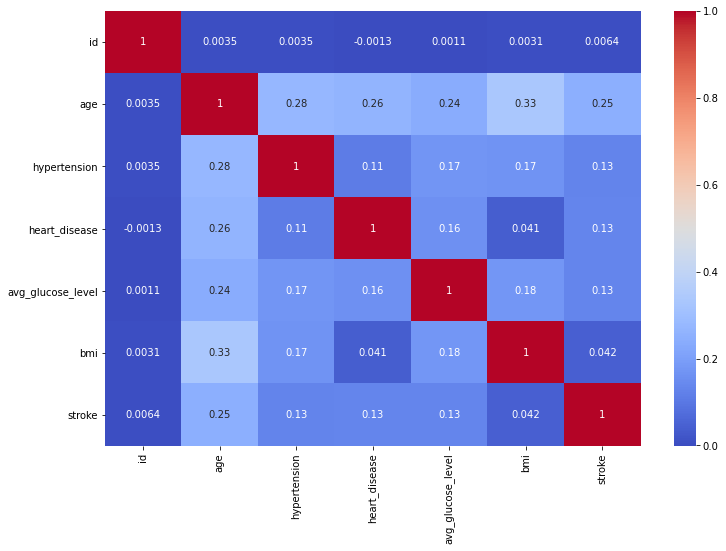

In [9]:
plt.figure (figsize = (12,8))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap = 'coolwarm', annot = True)

No great insights here, will have to perform more indepth EDA. The only moderate correlation is between stroke and age.

### 2.1: Cleaning data

In [10]:
stroke['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

I will drop the Other value row from the dataframe as it is 1 value out of 5000

In [11]:
stroke = stroke[stroke.gender != 'Other']

In [12]:
stroke['gender'].value_counts()

Female    2994
Male      2115
Name: gender, dtype: int64

In [13]:
stroke.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

201 null BMI values

In [14]:
stroke[stroke.isnull().any(axis=1)]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,8213,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,25226,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
27,61843,Male,58.0,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5039,42007,Male,41.0,0,0,No,Private,Rural,70.15,NaN,formerly smoked,0
5048,28788,Male,40.0,0,0,Yes,Private,Urban,191.15,NaN,smokes,0
5093,32235,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,NaN,smokes,0
5099,7293,Male,40.0,0,0,Yes,Private,Rural,83.94,NaN,smokes,0


**Conclusion**: I am going to drop the 201 rows. I still have just under 5000 samples to use for predicting.

In [15]:
stroke_clean = stroke.dropna(axis=0) #This is my new dataset

In [16]:
stroke_clean.shape

(4908, 12)

In [17]:
stroke_clean.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Very good

### 2.3: Deeper graphical and numerical EDA

#### 2.3.1: Stroke breakdown

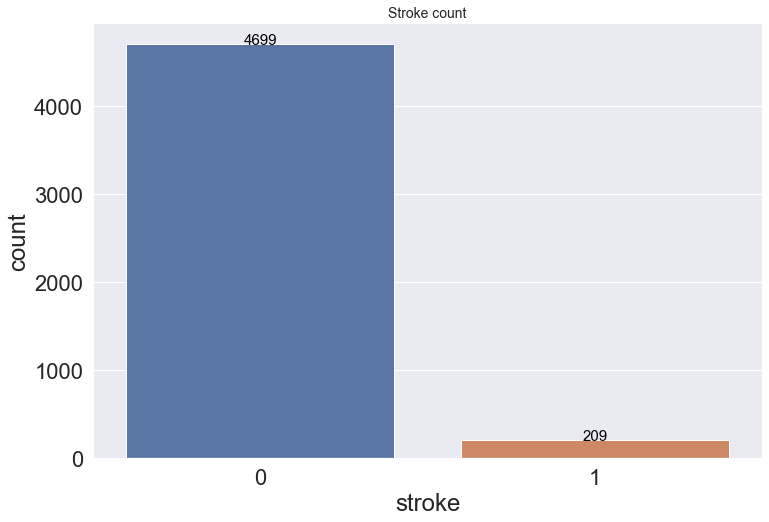

In [18]:
fig = plt.figure(figsize = (12,8));
sns.set_style("darkgrid")
sns.set(font_scale=2)
ax = sns.countplot(data=stroke_clean, x = 'stroke');
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x() + 0.4, p.get_height()), ha='center', color='black', size=15)
plt.title('Stroke count', fontsize = 14)
plt.show();

#### Baseline accuracy

In [19]:
100- ((209/(4699+209))*100)

95.74164629176855

#### 2.3.2: Gender breakdown

In [20]:
stroke_clean['gender'].value_counts()

Female    2897
Male      2011
Name: gender, dtype: int64

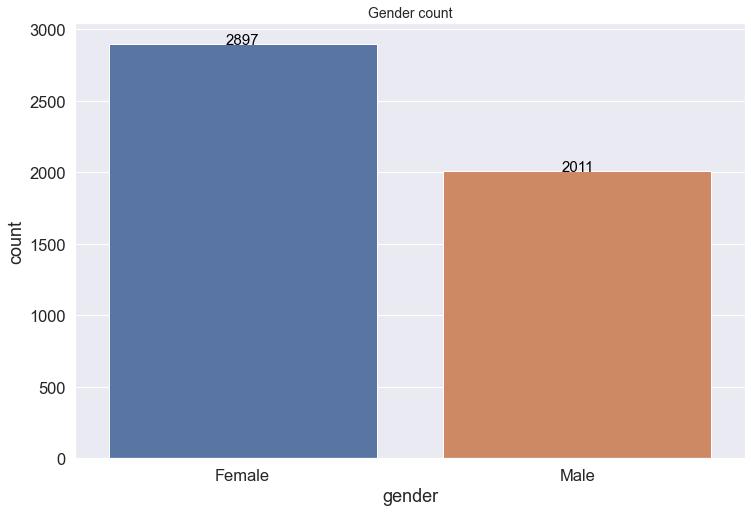

In [21]:
fig = plt.figure(figsize = (12,8));
sns.set_style("darkgrid")
sns.set(font_scale=1.5)
ax = sns.countplot(data=stroke_clean, x = 'gender', order = stroke['gender'].value_counts().index)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x() + 0.4, p.get_height()), ha='center', color='black', size=15)
plt.title('Gender count', fontsize = 14)
plt.show();


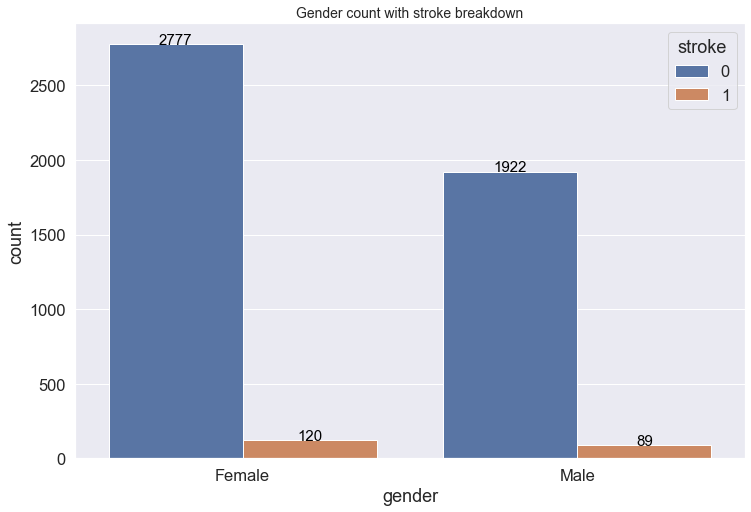

In [22]:
fig = plt.figure(figsize = (12,8));
sns.set_style("darkgrid")
sns.set(font_scale=1.5)
ax = sns.countplot(data=stroke_clean, x = 'gender', hue = 'stroke', order = stroke_clean['gender'].value_counts().index)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x() + 0.2, p.get_height()), ha='center', color='black', size=15)
plt.title('Gender count with stroke breakdown', fontsize = 14)
plt.show();


In [23]:
print ('Male stroke ratio: ', 89/1922, 'Female stroke ratio:' , 120/2777)

Male stroke ratio:  0.04630593132154006 Female stroke ratio: 0.04321209938782859


**Important**: Similar ratios for males and females to suffer stroke

#### 2.3.3: Smoking status analysis

In [24]:
stroke_clean['smoking_status'].value_counts()

never smoked       1852
Unknown            1483
formerly smoked     836
smokes              737
Name: smoking_status, dtype: int64

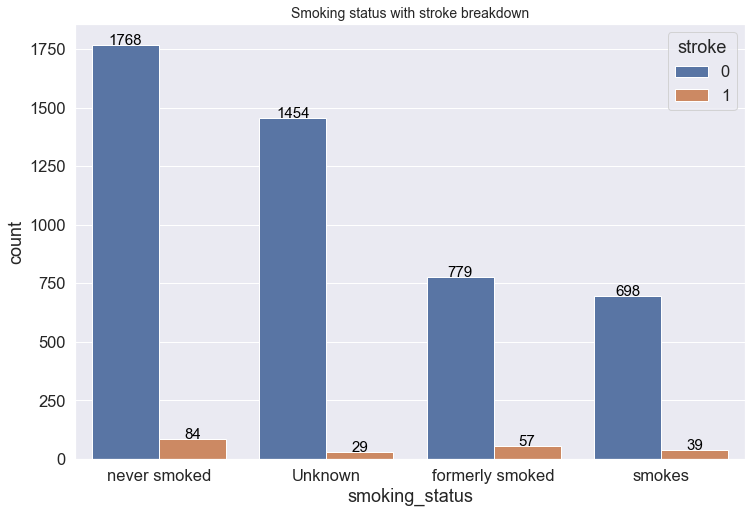

In [234]:
fig = plt.figure(figsize = (12,8));
sns.set_style("darkgrid")
sns.set(font_scale=1.5)
ax = sns.countplot(data=stroke_clean, x = 'smoking_status', hue = 'stroke', order = stroke_clean['smoking_status'].value_counts().index)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x() + 0.2, p.get_height()), ha='center', color='black', size=15)
plt.title('Smoking status with stroke breakdown', fontsize = 14)
plt.show();


In [26]:
84/1768, 29/1454, 57/779, 39/698

(0.04751131221719457,
 0.019944979367262722,
 0.07317073170731707,
 0.055873925501432664)

**Observations**: Smokers and former smokers have the highest percentage of suffering stroke

#### 2.3.4: Blood glucose level and BMI analysis

In [27]:
stroke_clean.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

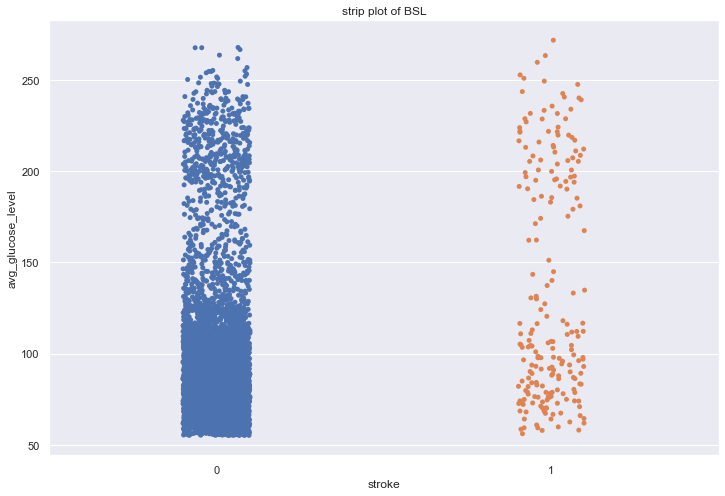

In [28]:
#stripplot for BSL and stroke
sns.set(rc={"figure.figsize":(12, 8)}); 
sns.stripplot(x='stroke',y='avg_glucose_level', data=stroke_clean);
plt.title ('strip plot of BSL');

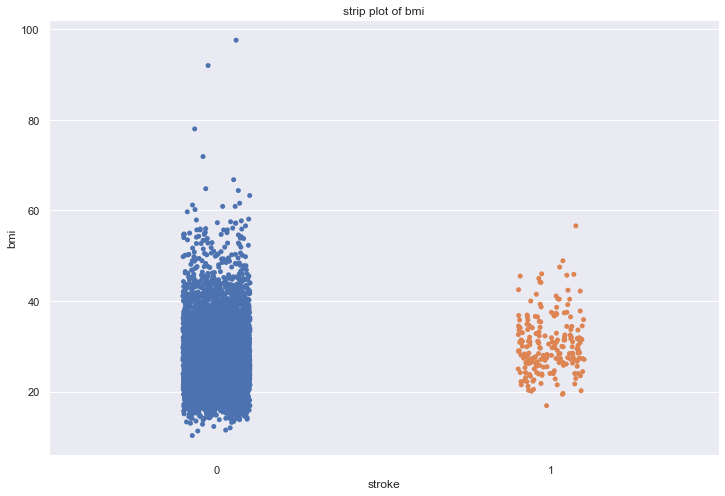

In [29]:
#strip plot for BMI and stroke
sns.set(rc={"figure.figsize":(12, 8)}); 
sns.stripplot(x='stroke',y='bmi', data=stroke_clean);
plt.title ('strip plot of bmi');

**Insight**: no clear link between stroke chance and BSL

#### 2.3.5: Combined BMI and BSL analysis

Text(0.5, 1.0, 'BGL vs BMI and hue = stroke')

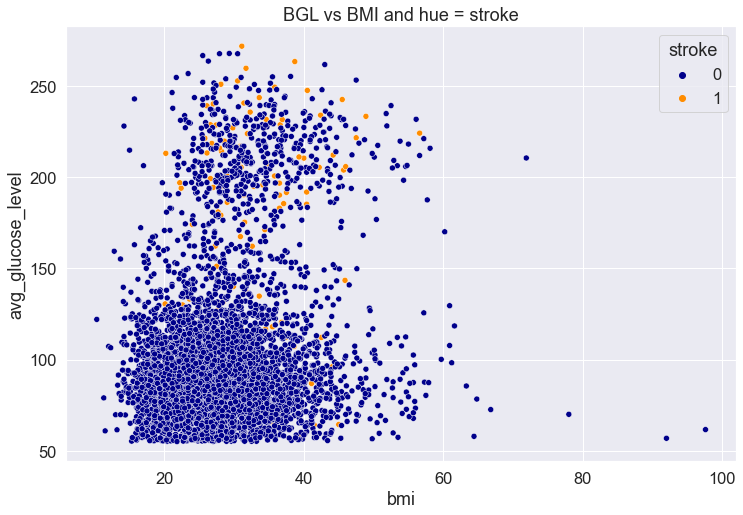

In [235]:
sns.scatterplot(data=stroke_clean, x="bmi", y="avg_glucose_level", hue='stroke', palette=['darkblue', 'darkorange'])
plt.title ('BGL vs BMI and hue = stroke')

**Observation**: No clear distinction between risk of stroke and bmi/BSL.

#### 2.3.6: stroke as a function of age

C:\Users\matta\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\matta\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


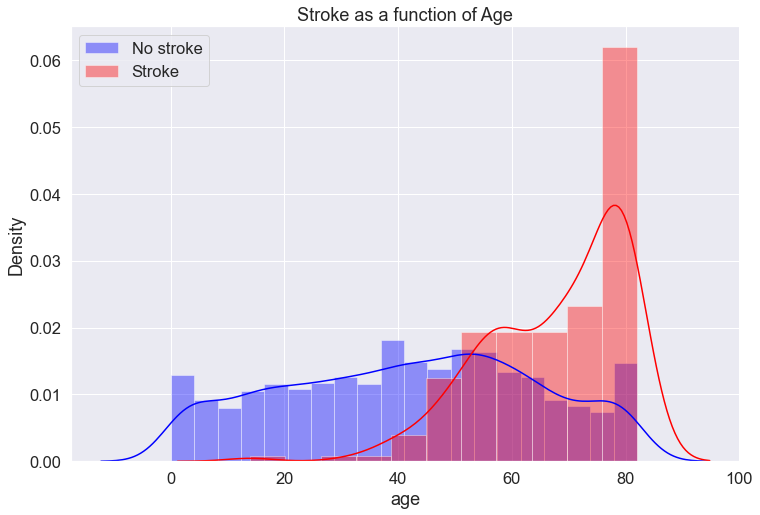

In [236]:
fig = plt.figure(figsize = (12,8));
sns.distplot(stroke_clean[stroke_clean['stroke'] == 0]["age"], color='blue',kde=True, label = 'No stroke');
sns.distplot(stroke_clean[stroke_clean['stroke'] == 1]["age"], color='red',kde=True, label = 'Stroke');
plt.title('Stroke as a function of Age');
plt.legend (loc = 'best')
plt.show();

**Insights**:

- A much clearer link between high age and stroke. The older, the more strokes.

In [32]:
#### Stats test:
stats.ttest_ind(stroke_clean[stroke_clean['stroke'] == 0]["age"],stroke_clean[stroke_clean['stroke'] == 1]["age"])[1]

3.8408903844882414e-61

**Note**: Very small p-value. This means that the two data sets are statistically significantly different, thus, there is a relation between age and stroke.

#### 2.3.7: Stroke and hypertension

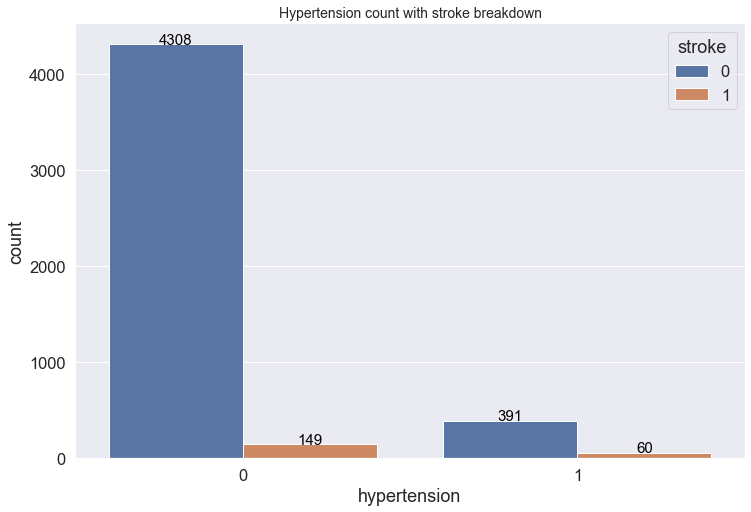

In [33]:
fig = plt.figure(figsize = (12,8));
sns.set_style("darkgrid")
sns.set(font_scale=1.5)
ax = sns.countplot(data=stroke_clean, x = 'hypertension', hue = 'stroke', order = stroke_clean['hypertension'].value_counts().index)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x() + 0.2, p.get_height()), ha='center', color='black', size=15)
plt.title('Hypertension count with stroke breakdown', fontsize = 14)
plt.show();


**Note**: no very close relation between the stroke and hypertension.

#### 2.3.7:  Previous heart attack and stroke

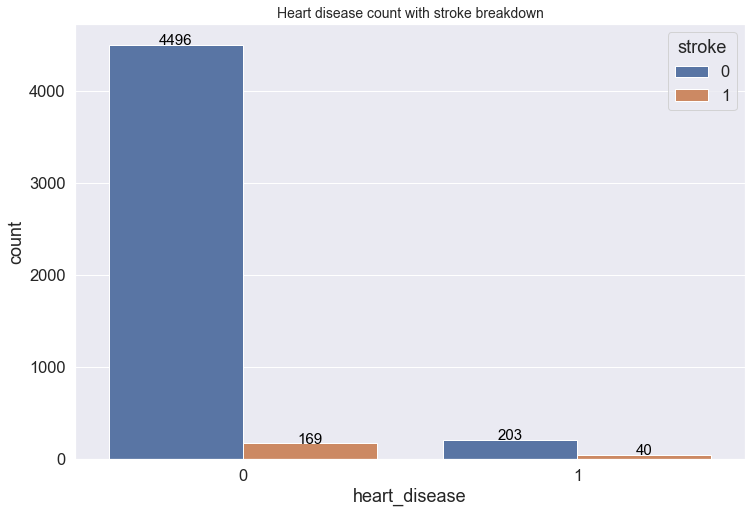

In [34]:
fig = plt.figure(figsize = (12,8));
sns.set_style("darkgrid")
sns.set(font_scale=1.5)
ax = sns.countplot(data=stroke_clean, x = 'heart_disease', hue = 'stroke', order = stroke_clean['heart_disease'].value_counts().index)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x() + 0.2, p.get_height()), ha='center', color='black', size=15)
plt.title('Heart disease count with stroke breakdown', fontsize = 14)
plt.show();

In [35]:
169/4496, 40/203

(0.037588967971530246, 0.19704433497536947)

**Insights**: Very strong link between heart disease and stroke

#### 2.3.8: Stroke and marriage

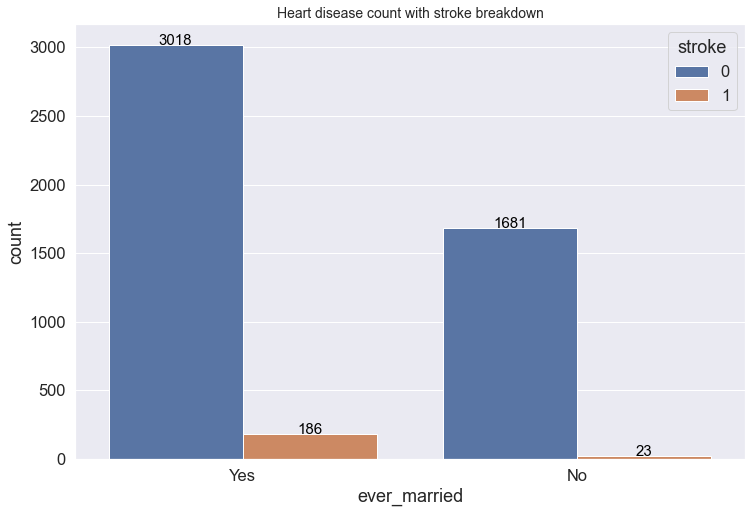

In [36]:
fig = plt.figure(figsize = (12,8));
sns.set_style("darkgrid")
sns.set(font_scale=1.5)
ax = sns.countplot(data=stroke_clean, x = 'ever_married', hue = 'stroke', order = stroke_clean['ever_married'].value_counts().index)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x() + 0.2, p.get_height()), ha='center', color='black', size=15)
plt.title('Heart disease count with stroke breakdown', fontsize = 14)
plt.show();

In [37]:
186/3018, 23/1681

(0.061630218687872766, 0.013682331945270671)

**Insights**: 5 times as likely to suffer a stroke if married... hmmmmm

#### 2.3.9: Stroke and work type

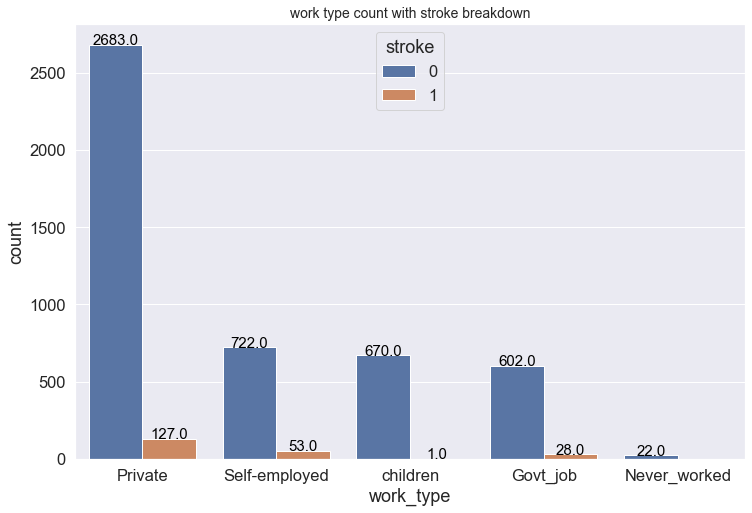

In [38]:
fig = plt.figure(figsize = (12,8));
sns.set_style("darkgrid")
sns.set(font_scale=1.5)
ax = sns.countplot(data=stroke_clean, x = 'work_type', hue = 'stroke', order = stroke_clean['work_type'].value_counts().index)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x() + 0.2, p.get_height()), ha='center', color='black', size=15)
plt.title('work type count with stroke breakdown', fontsize = 14)
plt.show();


In [39]:
127/2683, 53/722

(0.047335072679836006, 0.07340720221606649)

**Note**: self employed has the highest stroke rate

#### 2.3.9: Stroke and Residence type

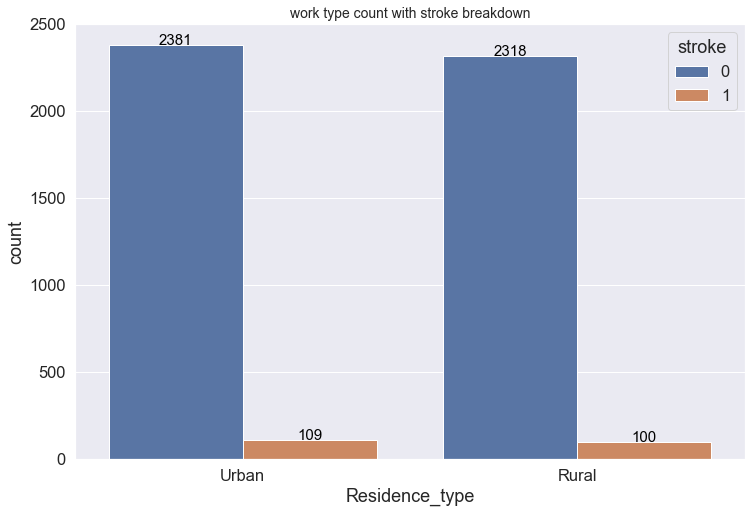

In [40]:
fig = plt.figure(figsize = (12,8));
sns.set_style("darkgrid")
sns.set(font_scale=1.5)
ax = sns.countplot(data=stroke_clean, x = 'Residence_type', hue = 'stroke', order = stroke_clean['Residence_type'].value_counts().index)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x() + 0.2, p.get_height()), ha='center', color='black', size=15)
plt.title('work type count with stroke breakdown', fontsize = 14)
plt.show();


No real difference between values.

### Overall insights from EDA

- The stroke % is 5% from the given data.
- **The models need to have an accuracy higher than 5% for true positives and 95% for true negatives.**
- Similar ratios for males and females to suffer stroke.
- **Smokers and former smokers have the highest percentage of suffering stroke.**
- No clear link between stroke chance and BSL
- No clear distinction between risk of stroke and bmi/BSL.
- **A much clearer link between high age and stroke. The older, the more strokes.**. proven with p-value.
- No very close relation between the stroke and hypertension.
- **Very strong link between heart disease and stroke.**
- **5 times as likely to suffer a stroke if married... hmmmmm**.
- **self employed has the highest stroke rate**.
- No real difference between values for residence types.

## 3: Modelling predictors

I will be using logistic regression, SVMs and Naive Bayes to form good models and see which one is the best predictor. I will begin by performing a gridsearch, then apply the best parameters to my models to see if i can make a predictor that is more than 95% accurate. (Thanks Joel)

### 3.1: Feature engineering and selection

I will prepare the relevant columns by converting them into binary or categorical data, and scale the continuous data to be more appropriate for analysis

In [41]:
stroke_clean.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [42]:
stroke_clean['ever_married'].value_counts()

Yes    3204
No     1704
Name: ever_married, dtype: int64

In [43]:
stroke_clean['work_type'].value_counts()

Private          2810
Self-employed     775
children          671
Govt_job          630
Never_worked       22
Name: work_type, dtype: int64

I need to convert ever_married and work_type into categorical data

In [44]:
stroke_clean['ever_married'] = stroke_clean['ever_married'].map({'Yes': 1, 'No': 0})

<ipython-input-44-a3ca7d349473>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stroke_clean['ever_married'] = stroke_clean['ever_married'].map({'Yes': 1, 'No': 0})


In [45]:
stroke_clean['ever_married'].value_counts()

1    3204
0    1704
Name: ever_married, dtype: int64

**Note**: Never married = 0 and married = 1

**Note on the cells below**: <br>
Initially I wanted to change the **work_type** and **smoking** into 4 categories from 1-4. However, It became evident that it is much easier to just dummy split this column without having to worry about the now-numerical values if I had converted it as shown below.<br>

After much trial and error, it was just easier, cleaner and more accurate to dummy split instead of assign values to this column.

In [46]:
#stroke_clean['work_type'] = stroke_clean['work_type'].map({'Never_worked': 0, 'Govt_job': 1, 'children': 2, 'Self-employed': 3, 'Private': 4})

In [47]:
#stroke_clean['work_type'].value_counts()

**Note**:   This is now defunct but I am keeping it here for the record
- Never worked = 0
- Govt job = 1
- children = 2
- self-employed = 3
- Private = 4

In [48]:
# stroke_clean['smoking_status'].value_counts()

In [49]:
#stroke_clean['smoking_status'] = stroke_clean['smoking_status'].map({'never smoked': 0, 'Unknown': 1, 'formerly smoked': 2, 'smokes': 3})

In [50]:
#stroke_clean['smoking_status'].value_counts()

#### 3.1.2: Assigning predictors and target variable

In [51]:
stroke_clean.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [52]:
#Assigning variables

y = stroke_clean['stroke'] #Target variable
X = stroke_clean[['age', 'heart_disease','ever_married','work_type','smoking_status', 'bmi', 'avg_glucose_level']] #Predictor matrix

In [53]:
y

0       1
2       1
3       1
4       1
5       1
       ..
5104    0
5106    0
5107    0
5108    0
5109    0
Name: stroke, Length: 4908, dtype: int64

In [54]:
X.head(4)

,age,heart_disease,ever_married,work_type,smoking_status,bmi,avg_glucose_level
0,67.0,1,1,Private,formerly smoked,36.6,228.69
2,80.0,1,1,Private,never smoked,32.5,105.92
3,49.0,0,1,Private,smokes,34.4,171.23
4,79.0,0,1,Self-employed,never smoked,24.0,174.12


Standardising the numerical data to produce more accurate predictions and better fitting models:

In [55]:
scaler = StandardScaler()
X[['age']] = scaler.fit_transform(X[['age']]);
X[['bmi']] = scaler.fit_transform(X[['bmi']]);
X[['avg_glucose_level']] = scaler.fit_transform(X[['avg_glucose_level']]);

<ipython-input-55-79e735ff3dda>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['age']] = scaler.fit_transform(X[['age']]);
C:\Users\matta\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-55-79e735ff3dda>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [56]:
X = pd.get_dummies(X)

In [57]:
X.head()

,age,heart_disease,ever_married,bmi,avg_glucose_level,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1.069938,1,1,0.981145,2.777797,0,0,1,0,0,0,1,0,0
2,1.646336,1,1,0.459086,0.014016,0,0,1,0,0,0,0,1,0
3,0.271847,0,1,0.701016,1.484266,0,0,1,0,0,0,0,0,1
4,1.601998,0,1,-0.623231,1.549325,0,0,0,1,0,0,0,1,0
5,1.690675,0,1,0.013426,1.821493,0,0,1,0,0,0,1,0,0


In [58]:
X.describe()

,age,heart_disease,ever_married,bmi,avg_glucose_level,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
count,4.908000e+03,4908.000000,4908.000000,4.908000e+03,4.908000e+03,4908.000000,4908.000000,4908.000000,4908.000000,4908.000000,4908.000000,4908.000000,4908.000000,4908.000000
mean,-8.174252e-16,0.049511,0.652812,1.255561e-16,-2.036766e-16,0.128362,0.004482,0.572535,0.157905,0.136716,0.302160,0.170334,0.377343,0.150163
std,1.000102e+00,0.216954,0.476125,1.000102e+00,1.000102e+00,0.334526,0.066808,0.494761,0.364689,0.343582,0.459241,0.375964,0.484771,0.357268
min,-1.897186e+00,0.000000,0.000000,-2.367672e+00,-1.129587e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.922739e-01,0.000000,0.000000,-6.868971e-01,-6.355077e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.015511e-02,0.000000,1.000000,-1.011725e-01,-3.065531e-01,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.595690e-01,0.000000,1.000000,5.354848e-01,1.845432e-01,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,1.735013e+00,1.000000,1.000000,8.748363e+00,3.746933e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Note**: The age, BMI and glucose columns have been converted to standard scale and the other categorical data has been dummy split.

I will choose the specific features that I want for my predictor matrix, leaving out any columns that could cause overfitting.

In [59]:
X = X[['age', 'heart_disease', 'ever_married', 'bmi', 'avg_glucose_level',
       'work_type_Govt_job', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes']]

In [60]:
X.head()

,age,heart_disease,ever_married,bmi,avg_glucose_level,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1.069938,1,1,0.981145,2.777797,0,1,0,0,1,0,0
2,1.646336,1,1,0.459086,0.014016,0,1,0,0,0,1,0
3,0.271847,0,1,0.701016,1.484266,0,1,0,0,0,0,1
4,1.601998,0,1,-0.623231,1.549325,0,0,1,0,0,1,0
5,1.690675,0,1,0.013426,1.821493,0,1,0,0,1,0,0


In [61]:
#### Test-train split:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42) #train test split

In [62]:
omgX = X
omgy = y
RFX = X
RFy = y

### 3.2: Logistic Regression

#### 3.2.1: Finding optimum parameters

In [63]:
#### Grid searching and finding optimal parameters:

from sklearn.model_selection import GridSearchCV

lr_params = {
    'penalty': ['l1','l2'],
    'C': [1, 10, 100]
}

grid = GridSearchCV(LogisticRegression(random_state=42), lr_params, return_train_score = True)

In [64]:
grid.fit(X_train, y_train)

C:\Users\matta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\matta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\matta\anaconda3\lib\site-packages\sklearn\model_selection\_v

C:\Users\matta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\matta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\matta\anaconda3\lib\site-packages\sklearn\model_selection\_v

GridSearchCV(estimator=LogisticRegression(random_state=42),
             param_grid={'C': [1, 10, 100], 'penalty': ['l1', 'l2']},
             return_train_score=True)

In [65]:
grid.best_params_ #Best parameters

{'C': 1, 'penalty': 'l2'}

In [66]:
grid.best_score_ #This is the best possible score using the data and the model. 

0.9605199267434887

**Analysis**: I should be able to get a 96% accuracy with the model and these parameters.

#### 3.2.2: Fitting and testing the model

In [67]:
model = LogisticRegression(penalty = 'l2', C = 1, random_state=42)

In [68]:
model.fit(X_train,y_train)
score_train = model.score(X_train, y_train)

# Calculate the score for Testing Data
score_test = model.score(X_test, y_test)

print (score_train, score_test)

0.9605196128374937 0.9460285132382892


In [69]:
for col in zip(X_train.columns, model.coef_[0]):
    print('{:<10s}  {:+.06f}'.format(col[0], col[1]))  # List of coefficients by predictor

age         +1.662419
heart_disease  +0.243493
ever_married  -0.074102
bmi         +0.035008
avg_glucose_level  +0.273640
work_type_Govt_job  -0.039016
work_type_Private  +0.098810
work_type_Self-employed  -0.401252
work_type_children  +0.370317
smoking_status_formerly smoked  +0.271836
smoking_status_never smoked  +0.159040
smoking_status_smokes  +0.495040


In [70]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_train)
round (accuracy_score(y_train, y_pred)*100, 3)

96.052

In [71]:
y_pred_class = model.predict(X_test)
con_mat_array = confusion_matrix(y_test, y_pred_class)
con_mat_array

array([[929,   0],
       [ 53,   0]], dtype=int64)

#### ROC curve for the LogReg

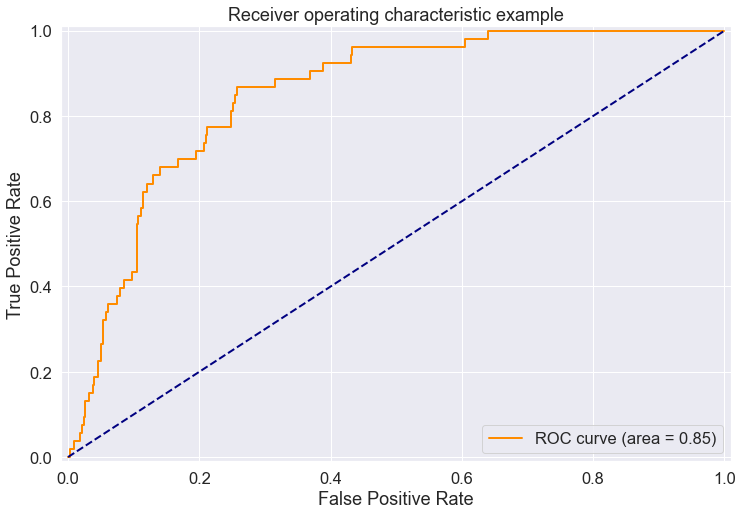

In [72]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = model.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

**Insights**:<br>

Fairly good model purely based off accuracy and the ROC, with the area being 0.85. <br>

However, due to the fact that the model is not picking up any of the negatives (true nor false) then this model is not practically useful, albeit statistically great.

#### Classification report

In [73]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred_class, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.95      1.00      0.97       929
     class 1       0.00      0.00      0.00        53

    accuracy                           0.95       982
   macro avg       0.47      0.50      0.49       982
weighted avg       0.89      0.95      0.92       982



C:\Users\matta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**VERY IMPORTANT**: The recall and f-1 scores agree with the confusion matrix. There are no negatives. The model is not predicting the no-stroke (class = 0) values

### 3.3: SVM 

#### 3.3.1 Getting best parameters

In [75]:
svc_params = {
    'C': [1, 10, 100],
    'gamma': [0.001, 0.0001],
    'kernel': ['linear','rbf']
}

grid2=GridSearchCV(svm.SVC(random_state=42), svc_params, n_jobs = 4)

In [76]:
grid2.fit(X_train, y_train)

GridSearchCV(estimator=SVC(random_state=42), n_jobs=4,
             param_grid={'C': [1, 10, 100], 'gamma': [0.001, 0.0001],
                         'kernel': ['linear', 'rbf']})

In [77]:
grid2.best_params_ #Best parameters

{'C': 1, 'gamma': 0.001, 'kernel': 'linear'}

In [78]:
grid2.best_score_

0.9602651496734251

As accurate as the logistic regression.

#### 3.3.2: Fitting and testing the model

In [79]:
# fit the model:
clf = svm.SVC(kernel = 'linear', C = 1, gamma = 0.001, random_state=42, probability = True)
clf.fit(X_train, y_train)

SVC(C=1, gamma=0.001, kernel='linear', probability=True, random_state=42)

In [80]:
score_train_svc = clf.score(X_train, y_train)

# Calculate the score for Testing Data
score_test_svc = clf.score(X_test, y_test)

print (score_train_svc, score_test_svc)

0.9602649006622517 0.9460285132382892


In [81]:
y_pred = clf.predict(X_train)
round (accuracy_score(y_train, y_pred)*100, 3)

96.026

In [82]:
y_pred_class_svc = clf.predict(X_test)
con_mat_array_svc = confusion_matrix(y_test, y_pred_class_svc)
con_mat_array_svc

array([[929,   0],
       [ 53,   0]], dtype=int64)

In [83]:
print(classification_report(y_test, y_pred_class_svc, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.95      1.00      0.97       929
     class 1       0.00      0.00      0.00        53

    accuracy                           0.95       982
   macro avg       0.47      0.50      0.49       982
weighted avg       0.89      0.95      0.92       982



C:\Users\matta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Note**: Same as with the LogReg. Not registering any values for the negative class.

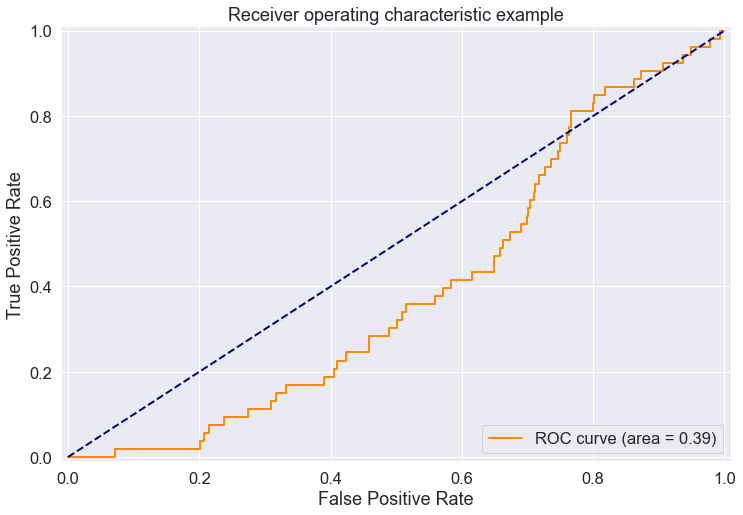

In [84]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds2 = clf.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr2, tpr2, _2 = roc_curve(y_test, preds2)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc2 = auc(fpr2, tpr2)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr2, tpr2, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

**Analysis**: This is actually not good. This means that the model fails to discriminate between false and  true positives. Even if I flip the variables, the area would still only be 0.61.

**Further analysis**: Let's see if we can notice anything from the learning curve.

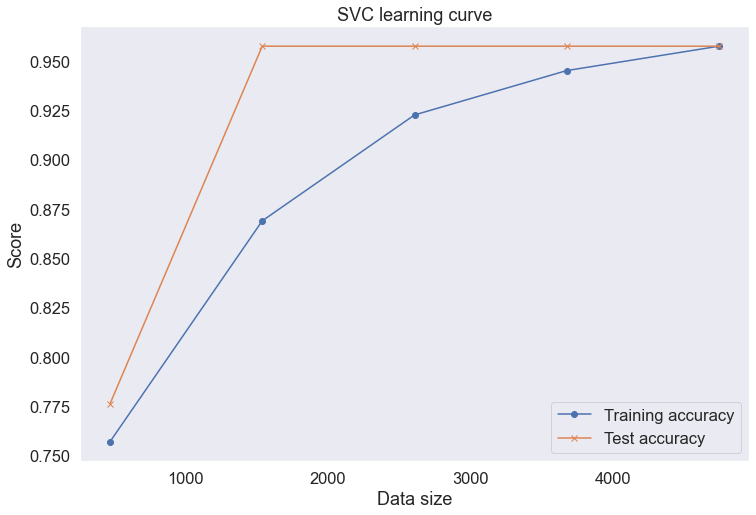

In [86]:
from sklearn.model_selection import learning_curve
estimator = svm.SVC(C=1, gamma=0.001, kernel='linear', random_state=42)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X, y, cv=30,return_times=True)

plt.figure (figsize = (12,8))
plt.plot(train_sizes,np.mean(train_scores,axis=1), label = 'Training accuracy', marker = 'o')
plt.plot(train_sizes,np.mean(test_scores,axis=1), label = 'Test accuracy', marker = 'x')
plt.xlabel('Data size')
plt.ylabel('Score')
plt.title('SVC learning curve')
plt.grid()
plt.legend(loc="lower right")

### 3.4 Naive Bayes

In [88]:
from sklearn.naive_bayes import GaussianNB
cls = GaussianNB()
cls.fit(X_train, y_train)

GaussianNB()

In [89]:
score_train_GNB = cls.score(X_train, y_train)

# Calculate the score for Testing Data
score_test_GNB = cls.score(X_test, y_test)

print (score_train_GNB, score_test_GNB)

0.8535404992358635 0.835030549898167


Less accurate than the SVM and the logistic regression. Need more evaluation.

In [90]:
y_pred_class_GNB = cls.predict(X_test)
con_mat_array_GNB = confusion_matrix(y_test, y_pred_class_GNB)
con_mat_array_GNB

array([[793, 136],
       [ 26,  27]], dtype=int64)

In [91]:
print(classification_report(y_test, y_pred_class_GNB, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.97      0.85      0.91       929
     class 1       0.17      0.51      0.25        53

    accuracy                           0.84       982
   macro avg       0.57      0.68      0.58       982
weighted avg       0.92      0.84      0.87       982



**Note** We actually have some detection of negative values for the outcome. This is good. A large number of false positives, however. Note also that the false negatives is also relatively small. Accuracy is 0.84, recall is 0.51 and f-1 is 0.25. Not great for detecting stroke.

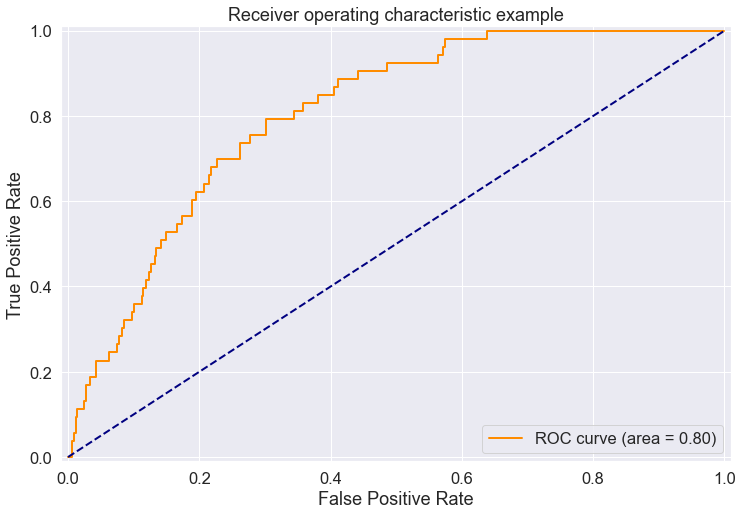

In [92]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds3 = cls.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr3, tpr3, _3 = roc_curve(y_test, preds3)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc3 = auc(fpr3, tpr3)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr3, tpr3, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc3)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

### 3.5 ROC curve for all 3 models

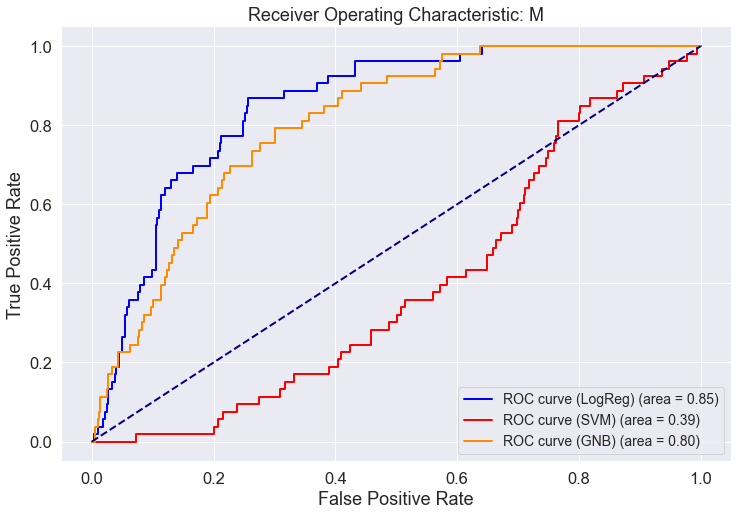

In [93]:
plt.figure(figsize=[12,8])
lw = 2
plt.plot(fpr, tpr, color='blue', lw = lw, label = 'ROC curve (LogReg) (area = %0.2f)' % roc_auc)
plt.plot(fpr2, tpr2, color='red', lw = lw, label = 'ROC curve (SVM) (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, color='darkorange', lw = lw, label = 'ROC curve (GNB) (area = %0.2f)' % roc_auc3)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver Operating Characteristic: M', fontsize=18)
plt.legend(loc="lower right", fontsize = 14)
plt.show()

## Conclusions from these models:

- The target column is heavily unbalanced (20:1 ratio) thus, algorithms such as LogReg completely miss the negative results.
- The issue becomes apparent when the confusion matrices show zeros in the negative column. That means the models (both SVM and LogReg) are missing the negative predictions, and just making false positive predictions.
- Need to modify the training data to make models better. Will try **undersampling** and **SMOTE** and see if that helps make better models.

## 4: Undersampling

I will be using the same 3 models as earlier, but this time with an undersample that should hopefully yield more negative results.

In [94]:
from imblearn.under_sampling import RandomUnderSampler
import collections
rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable
X_rus, y_rus = rus.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.20, random_state=42) #train test split

print('original dataset shape:', collections.Counter(y))
print('Resample dataset shape', collections.Counter(y_rus))

original dataset shape: Counter({0: 4699, 1: 209})
Resample dataset shape Counter({0: 209, 1: 209})


### 4.1 LogReg

Grid searching for LogReg:

In [95]:
grid.fit(X_train, y_train)

C:\Users\matta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\matta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\matta\anaconda3\lib\site-packages\sklearn\model_selection\_v

C:\Users\matta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\matta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\matta\anaconda3\lib\site-packages\sklearn\model_selection\_v

GridSearchCV(estimator=LogisticRegression(random_state=42),
             param_grid={'C': [1, 10, 100], 'penalty': ['l1', 'l2']},
             return_train_score=True)

In [96]:
grid.best_score_ #This is the best possible score using the data and the model. 

0.7305744007236544

In [97]:
grid.best_params_

{'C': 1, 'penalty': 'l2'}

**Note**: Way less accuracy than the baseline. Also less accurate than the model used on the original data.

#### 4.1.1: Modelling and fitting LogReg

In [98]:
model = LogisticRegression(penalty = 'l2', C = 1, random_state=42)

In [99]:
model.fit(X_train,y_train)
score_train = model.score(X_train, y_train)

# Calculate the score for Testing Data
score_test = model.score(X_test, y_test)

print (score_train, score_test)

0.7455089820359282 0.8095238095238095


In [100]:
y_pred_class = model.predict(X_test)
con_mat_array = confusion_matrix(y_test, y_pred_class)
con_mat_array

array([[31, 11],
       [ 5, 37]], dtype=int64)

**Analysis**: There is a good distribution of true values. A small number of error types I and II. A useable model, so far. Arguably more useful than the earlier LogReg used on the original data.

**ROC Curve for the LogReg**

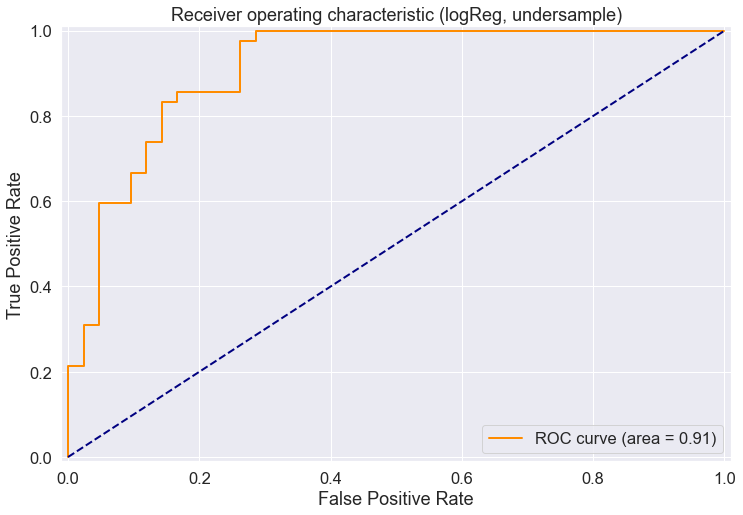

In [101]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = model.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (logReg, undersample)')
plt.legend(loc = "lower right")
plt.show()

In [102]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred_class, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.86      0.74      0.79        42
     class 1       0.77      0.88      0.82        42

    accuracy                           0.81        84
   macro avg       0.82      0.81      0.81        84
weighted avg       0.82      0.81      0.81        84



**Analysis**: Much more useable model. How useable exactly depends on where one draws the line for the  recall and f-1 scores. accuracy 0.81, recall 0.88, f1 0.82

### 4.2: SVM

Grid search for SVM:

In [103]:
grid2.fit(X_train, y_train)

GridSearchCV(estimator=SVC(random_state=42), n_jobs=4,
             param_grid={'C': [1, 10, 100], 'gamma': [0.001, 0.0001],
                         'kernel': ['linear', 'rbf']})

In [104]:
grid2.best_score_ 

0.7275893260967887

In [105]:
grid2.best_params_

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

Less accurate than the baseline and the LogReg. Will examine further.

In [106]:
clf = svm.SVC(kernel = 'rbf', C = 100, gamma = 0.001, probability = True, random_state=42)
clf.fit(X_train, y_train)

SVC(C=100, gamma=0.001, probability=True, random_state=42)

In [107]:
score_train_svc = clf.score(X_train, y_train)

# Calculate the score for Testing Data
score_test_svc = clf.score(X_test, y_test)

print (score_train_svc, score_test_svc)

0.7335329341317365 0.8571428571428571


In [108]:
y_pred_class_svc = clf.predict(X_test)
con_mat_array_svc = confusion_matrix(y_test, y_pred_class_svc)
con_mat_array_svc

array([[31, 11],
       [ 1, 41]], dtype=int64)

**Analysis**: Very good model. Much less false negatives (1) when compared to the LogReg.

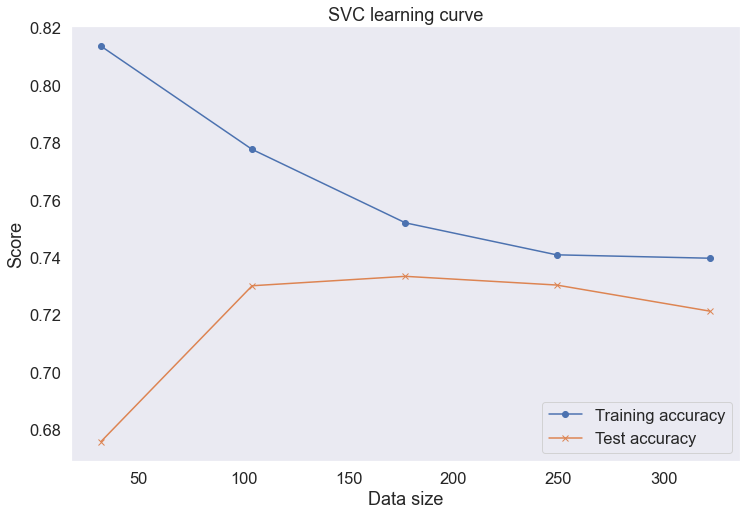

In [109]:
estimator = svm.SVC(C=100, gamma=0.001, kernel='rbf', random_state=42)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X_train, y_train, cv=30,return_times=True)

plt.figure (figsize = (12,8))
plt.plot(train_sizes,np.mean(train_scores,axis=1), label = 'Training accuracy', marker = 'o')
plt.plot(train_sizes,np.mean(test_scores,axis=1), label = 'Test accuracy', marker = 'x')
plt.xlabel('Data size')
plt.ylabel('Score')
plt.title('SVC learning curve')
plt.grid()
plt.legend(loc="lower right")

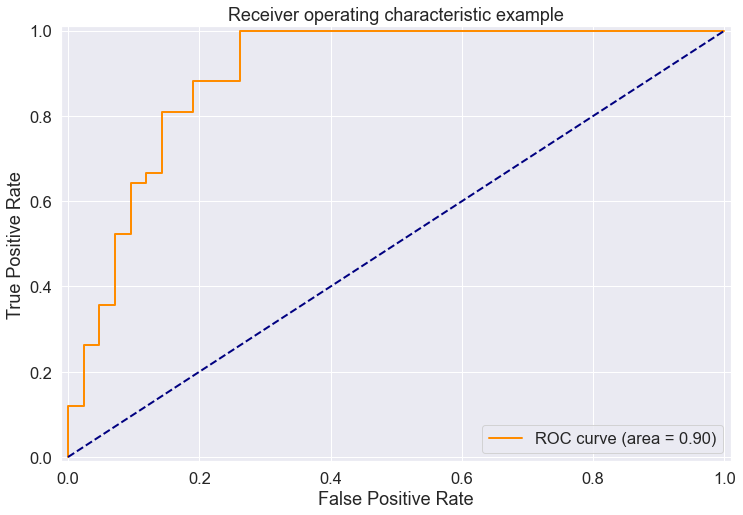

In [110]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds2 = clf.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr2, tpr2, _2 = roc_curve(y_test, preds2)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc2 = auc(fpr2, tpr2)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr2, tpr2, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

In [111]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred_class_svc, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.97      0.74      0.84        42
     class 1       0.79      0.98      0.87        42

    accuracy                           0.86        84
   macro avg       0.88      0.86      0.86        84
weighted avg       0.88      0.86      0.86        84



**Note**: Good model, good distribution of analytical data. Accuracy = 0.86, recall = 0.98, f1 = 0.87. Very good predictor

### 4.3: Naive Bayes

In [112]:
cls = GaussianNB()
cls.fit(X_train, y_train)

GaussianNB()

In [113]:
score_train_GNB = cls.score(X_train, y_train)

# Calculate the score for Testing Data
score_test_GNB = cls.score(X_test, y_test)

print (score_train_GNB, score_test_GNB)

0.7155688622754491 0.7976190476190477


hmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm

In [114]:
y_pred_class_GNB = cls.predict(X_test)
con_mat_array_GNB = confusion_matrix(y_test, y_pred_class_GNB)
con_mat_array_GNB

array([[27, 15],
       [ 2, 40]], dtype=int64)

**Analysis**: Also a good model, much higher true positives, however. Still a low number of false negatives.

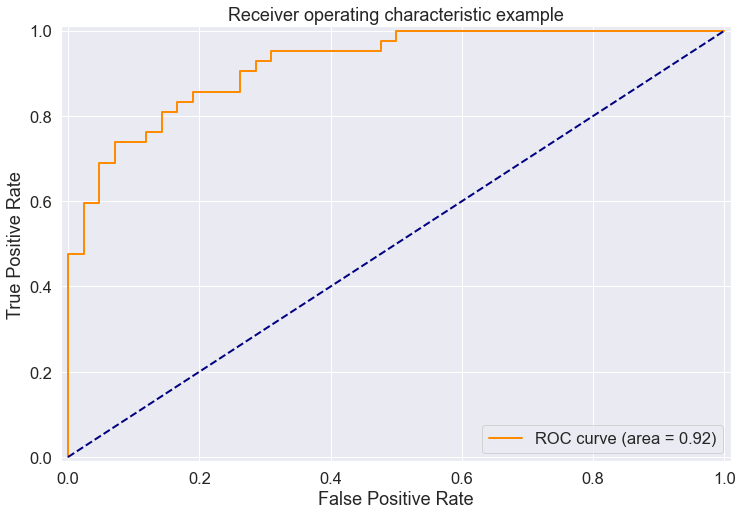

In [115]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds3 = cls.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr3, tpr3, _3 = roc_curve(y_test, preds3)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc3 = auc(fpr3, tpr3)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr3, tpr3, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc3)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

In [116]:
print(classification_report(y_test, y_pred_class_GNB, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.93      0.64      0.76        42
     class 1       0.73      0.95      0.82        42

    accuracy                           0.80        84
   macro avg       0.83      0.80      0.79        84
weighted avg       0.83      0.80      0.79        84



**Notes:** Accuracy = 0.8, recall = 0.95, f1 = 0.82. Good, but not as good or useful as the SVM.

### 4.4: All 3 graphs

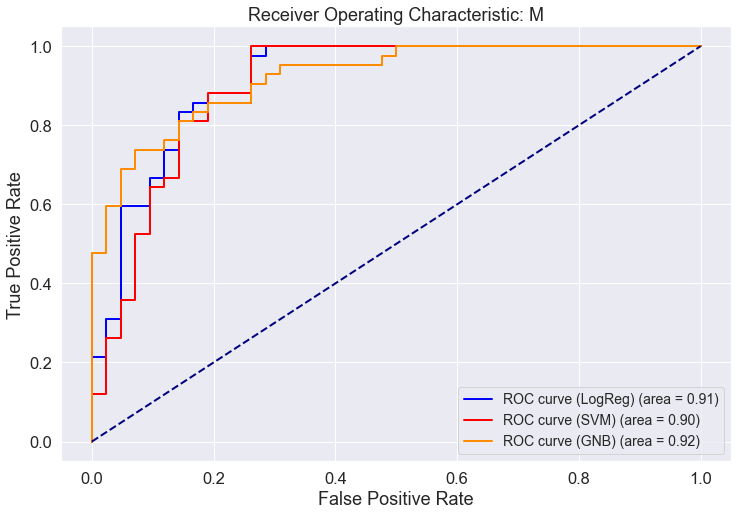

In [117]:
plt.figure(figsize=[12,8])
lw = 2
plt.plot(fpr, tpr, color='blue', lw = lw, label = 'ROC curve (LogReg) (area = %0.2f)' % roc_auc)
plt.plot(fpr2, tpr2, color='red', lw = lw, label = 'ROC curve (SVM) (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, color='darkorange', lw = lw, label = 'ROC curve (GNB) (area = %0.2f)' % roc_auc3)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver Operating Characteristic: M', fontsize=18)
plt.legend(loc="lower right", fontsize = 14)
plt.show()

**Analysis**: Overall, using undersampling has produced better models, albeit less accurate ones. Higher usefulness with some insightful data. Will finalise analysis once SMOTE method is fully explored.

## 5: SMOTE

In [118]:
# import library
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit predictor and target variable
X_smote, y_smote = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.20, random_state=42) #train test split

print('Original dataset shape', collections.Counter(y))
print('Resample dataset shape', collections.Counter(y_smote))

Original dataset shape Counter({0: 4699, 1: 209})
Resample dataset shape Counter({1: 4699, 0: 4699})


## 5.1: LogReg

In [119]:
grid.fit(X_train, y_train)

C:\Users\matta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\matta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\matta\anaconda3\lib\site-packages\sklearn\model_selection\_v

C:\Users\matta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\matta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\matta\anaconda3\lib\site-packages\sklearn\model_selection\_v

GridSearchCV(estimator=LogisticRegression(random_state=42),
             param_grid={'C': [1, 10, 100], 'penalty': ['l1', 'l2']},
             return_train_score=True)

In [120]:
grid.best_score_

0.7939601293866169

In [121]:
grid.best_params_

{'C': 10, 'penalty': 'l2'}

In [122]:
model = LogisticRegression(penalty = 'l2', C = 10, random_state=42)

In [123]:
model.fit(X_train,y_train)
score_train = model.score(X_train, y_train)

# Calculate the score for Testing Data
score_test = model.score(X_test, y_test)

print (score_train, score_test)

0.7928970470869913 0.7952127659574468


In [124]:
y_pred_class = model.predict(X_test)
con_mat_array = confusion_matrix(y_test, y_pred_class)
con_mat_array

array([[709, 213],
       [172, 786]], dtype=int64)

In [125]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred_class, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.80      0.77      0.79       922
     class 1       0.79      0.82      0.80       958

    accuracy                           0.80      1880
   macro avg       0.80      0.79      0.79      1880
weighted avg       0.80      0.80      0.80      1880



**Notes**: Acceptable values, but the undersampling model was better.

## 5.2: SVM

In [126]:
svc_params = {
    'C': [1, 10, 100],
    'gamma': [0.001, 0.0001],
    'kernel': ['linear','rbf']
}
grid2=GridSearchCV(svm.SVC(random_state=42), svc_params, n_jobs = 4)

In [127]:
grid2.fit(X_train, y_train)

GridSearchCV(estimator=SVC(random_state=42), n_jobs=4,
             param_grid={'C': [1, 10, 100], 'gamma': [0.001, 0.0001],
                         'kernel': ['linear', 'rbf']})

In [128]:
grid2.best_params_

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

In [129]:
clf = svm.SVC(kernel = 'rbf', C = 100, gamma = 0.001, probability = True, random_state=42)
clf.fit(X_train, y_train)

SVC(C=100, gamma=0.001, probability=True, random_state=42)

In [130]:
score_train_svc = clf.score(X_train, y_train)

# Calculate the score for Testing Data
score_test_svc = clf.score(X_test, y_test)

print (score_train_svc, score_test_svc)

0.8032721468475659 0.8106382978723404


In [131]:
y_pred_class_svc = clf.predict(X_test)
con_mat_array_svc = confusion_matrix(y_test, y_pred_class_svc)
con_mat_array_svc

array([[691, 231],
       [125, 833]], dtype=int64)

In [132]:
print(classification_report(y_test, y_pred_class_svc, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.85      0.75      0.80       922
     class 1       0.78      0.87      0.82       958

    accuracy                           0.81      1880
   macro avg       0.81      0.81      0.81      1880
weighted avg       0.81      0.81      0.81      1880



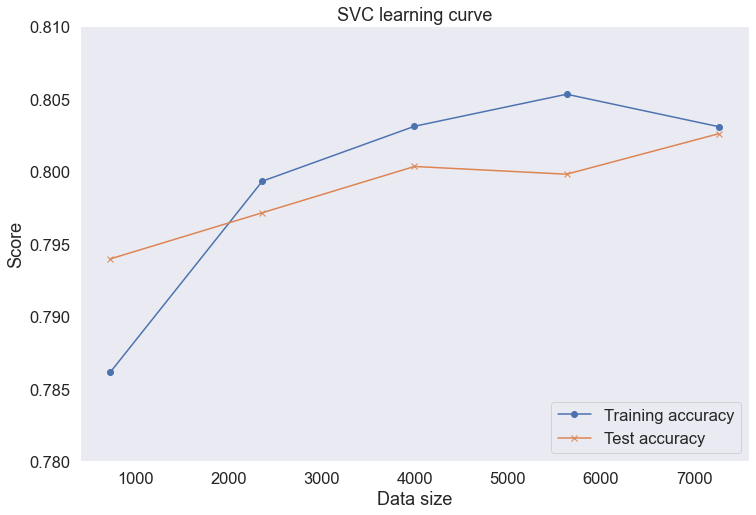

In [135]:
estimator = svm.SVC(C=100, gamma=0.001, kernel='rbf', random_state=42)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X_train, y_train, cv=30,return_times=True, n_jobs = 5)

plt.figure (figsize = (12,8))
plt.plot(train_sizes,np.mean(train_scores,axis=1), label = 'Training accuracy', marker = 'o')
plt.plot(train_sizes,np.mean(test_scores,axis=1), label = 'Test accuracy', marker = 'x')
plt.ylim([0.78, 0.81])
plt.xlabel('Data size')
plt.ylabel('Score')
plt.title('SVC learning curve')
plt.grid()
plt.legend(loc="lower right")

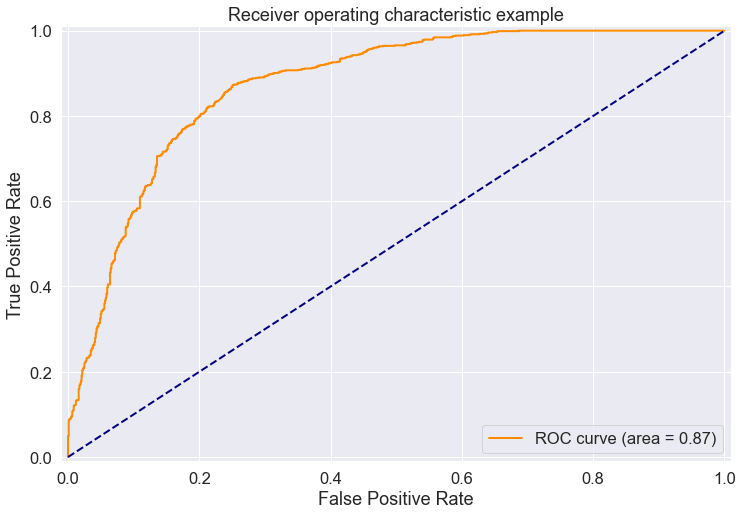

In [136]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds2 = clf.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr2, tpr2, _2 = roc_curve(y_test, preds2)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc2 = auc(fpr2, tpr2)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr2, tpr2, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

**Notes:** accuracy = 0.87, recall = 0.81, f1 = 0.82. ROC AUC = 0.87. Overall, this is a good model. The model trained on the undersampled training set, however.

### 5.3: GNB

In [137]:
cls = GaussianNB()
cls.fit(X_train, y_train)

GaussianNB()

In [138]:
score_train_GNB = cls.score(X_train, y_train)

# Calculate the score for Testing Data
score_test_GNB = cls.score(X_test, y_test)

print (score_train_GNB, score_test_GNB)

0.7184091513700452 0.7138297872340426


In [139]:
y_pred_class_GNB = cls.predict(X_test)
con_mat_array_GNB = confusion_matrix(y_test, y_pred_class_GNB)
con_mat_array_GNB

array([[412, 510],
       [ 28, 930]], dtype=int64)

In [140]:
print(classification_report(y_test, y_pred_class_GNB, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.94      0.45      0.60       922
     class 1       0.65      0.97      0.78       958

    accuracy                           0.71      1880
   macro avg       0.79      0.71      0.69      1880
weighted avg       0.79      0.71      0.69      1880



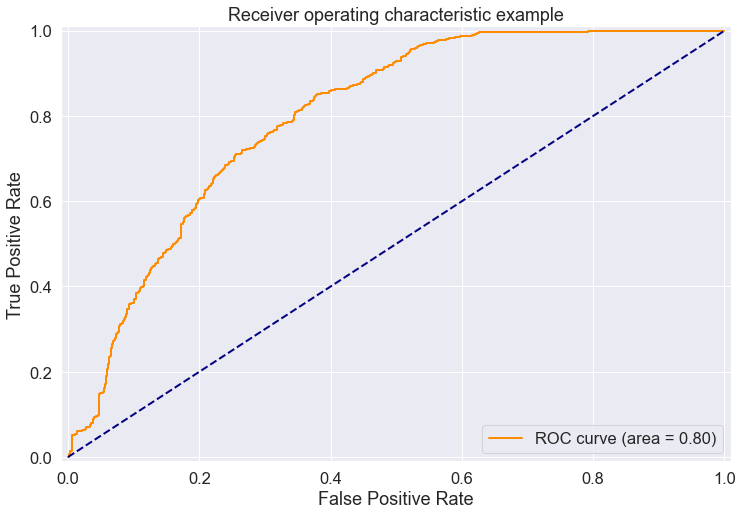

In [141]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds3 = cls.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr3, tpr3, _3 = roc_curve(y_test, preds3)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc3 = auc(fpr3, tpr3)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr3, tpr3, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc3)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

**Notes:** High recall, but moderate accuracy and f-1 score. Not as reliable as the other model. AUC also lower.

### 5.4 All three graphs again - with SMOTE

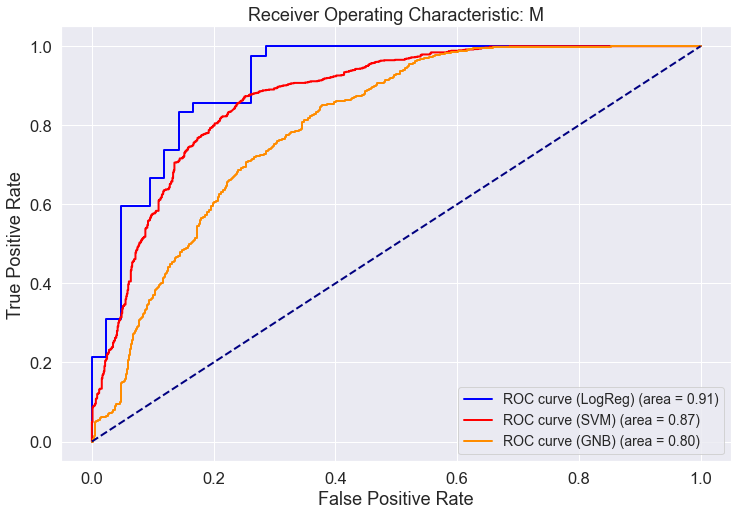

In [142]:
plt.figure(figsize=[12,8])
lw = 2
plt.plot(fpr, tpr, color='blue', lw = lw, label = 'ROC curve (LogReg) (area = %0.2f)' % roc_auc)
plt.plot(fpr2, tpr2, color='red', lw = lw, label = 'ROC curve (SVM) (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, color='darkorange', lw = lw, label = 'ROC curve (GNB) (area = %0.2f)' % roc_auc3)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver Operating Characteristic: M', fontsize=18)
plt.legend(loc="lower right", fontsize = 14)
plt.show()

## 6: Takeaways from the program (So far)

#### Before undersampling and smote:

- The target column is heavily unbalanced (20:1 ratio) thus, algorithms such as LogReg completely miss the negative results.
- The issue becomes apparent when the confusion matrices show zeros in the negative column. That means the models (both SVM and LogReg) are missing the negative predictions, and just making false positive predictions.
- Need to modify the training data to make models better. Will try **undersampling** and **SMOTE** and see if that helps make better models.

#### After undersampling and smote:

- The models performed better with the undersampling than the SMOTE.
- LogReg performed best when using SMOTE.
- GNB performed best when undersampling

#### Score before undersampling or SMOTE

| Model | Recall score |   F1 score    | Accuracy |
|:--------------|:-----------:|:----------:|:----------:|
| **Logistic Regression** | 1    | 0   | 0.95 |
| **SVM**      | 1 |    0   | 0.95|
| **GaussianNB**      | 0.51 |    0.25  | 0.84|

#### Scores after undersampling

| Model | Recall score |   F1 score    |Accuracy |
|:--------------|:-----------:|:----------:|:----------:|
| **Logistic Regression** | 0.88   |   0.82    |0.81 |
| **SVM**      | 0.98 |    0.87|  0.86|
| **GaussianNB**      | 0.95 |   0.82|  0.80|

#### Scores after SMOTE

| Model | Recall score |   F1 score    |Accuracy |
|:--------------|:-----------:|:----------:|:----------:|
| **Logistic Regression** | 0.82   |  0.81  |0.80 |
| **SVM**      | 0.87 |   0.82   |0.81 |
| **GaussianNB**      | 0.96 | 0.77 |0.72 |

#### Using recall

Recall: Model recall score represents the model’s ability to correctly predict the positives out of actual positives. This is unlike precision which measures how many predictions made by models are actually positive out of all positive predictions made. For example: If your machine learning model is trying to identify positive reviews, the recall score would be what percent of those positive reviews did your machine learning model correctly predict as a positive. In other words, it measures how good our machine learning model is at identifying all actual positives out of all positives that exist within a dataset. The higher the recall score, the better the machine learning model is at identifying both positive and negative examples. **Recall score is a useful measure of success of prediction when the classes are very imbalanced**. From : https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/

#### Academic notes on recall and F1 score

- Optimizing for recall helps with minimizing the chance of not detecting a malignant cancer. However, this comes at the cost of predicting malignant cancer in patients although the patients are healthy (a high number of FP).
- Optimizing for precision helps with correctness if the patient has a malignant cancer. However, this comes at the cost of missing malignant cancer more frequently (a high number of FN).

- Precision-Recall score is a useful measure of success of prediction when the classes are very imbalanced. 
- Accuracy score is used to measure the model performance in terms of measuring the ratio of sum of true positive and true negatives out of all the predictions made.
- F1-score is harmonic mean of precision and recall score and is used as a metrics in the scenarios where choosing either of precision or recall score can result in compromise in terms of model giving high false positives and false negatives respectively.

## Conclusion (so far): 

Creating and fitting a model based on SVM, standardised data, specifically chosen features and undersampling, we found that we get an accuracy of 86% (lower than the baseline accuracy (94%) with very high recall (likelihood of predicting strokes) at 0.98 and a very good f1-score at 0.87.

Although the model accuracy is less than the baseline accuracy, the model is good for the following reasons:
 - Very high recall, very good likelihood of predicting stroke (True Positive).
 - A high f1-score, very low likelihood of missing a stroke prediction (False negative).
 - Some false positives, but those can be cleared with further medical examination.
 - The pros outweigh the cons of the model, therefore it is a very good preliminary diagnosis tool.

## 7: PCA and KNN

In the following few cells, I will try PCA then KNN to see if I can produce a better model.

In [143]:
from sklearn.decomposition import PCA

pca=PCA()

# Fit Xs
pca.fit(omgX)

PCA()

### 7.1: Explained variance plot

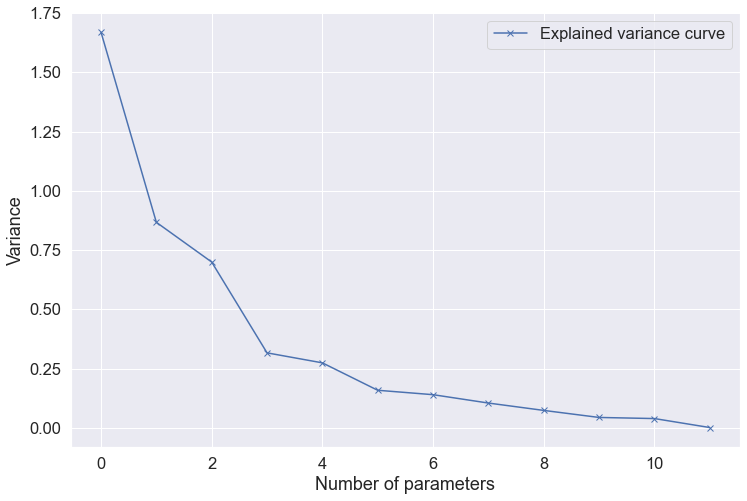

In [144]:
# Plot explained_variance_
plt.figure (figsize = (12,8))
plt.plot (pca.explained_variance_, label = 'Explained variance curve', marker = 'x')
plt.xlabel ('Number of parameters')
plt.ylabel ('Variance')
plt.legend (loc = 'best')

#### Dimensionality reduction

In [145]:
# Apply dimensionality reduction to Xs using transform
pca = PCA(n_components = 6)
comps = pca.fit_transform(omgX)

In [146]:
X_train, X_test, y_train, y_test = train_test_split(comps, omgy, test_size=0.20, random_state=42) #train test split

#### 7.2: Using KNN as a model after PCA

In [147]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [148]:
y_pred = knn.predict(X_test)

In [149]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9215885947046843

In [150]:
con_mat_array = confusion_matrix(y_test, y_pred)
con_mat_array

array([[902,  27],
       [ 50,   3]], dtype=int64)

In [155]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.95      0.97      0.96       929
     class 1       0.10      0.06      0.07        53

    accuracy                           0.92       982
   macro avg       0.52      0.51      0.52       982
weighted avg       0.90      0.92      0.91       982



**Notes**: The KNN is pretty good, actually, but mostly for the class 0. Very low recall and f-1 score. Accuracy is 0.92, but still.<br>

**Below**, I will use GNB, LogReg and SVC on the PCA'd data.

In [156]:
#### 7.3: GNB after PCA

In [157]:
cls.fit(X_train, y_train)
score_train_GNB = cls.score(X_train, y_train)

# Calculate the score for Testing Data
score_test_GNB = cls.score(X_test, y_test)

print (score_train_GNB, score_test_GNB)

0.9531329597554763 0.9327902240325866


In [158]:
y_pred_class_GNB = cls.predict(X_test)
con_mat_array_GNB = confusion_matrix(y_test, y_pred_class_GNB)
con_mat_array_GNB

array([[915,  14],
       [ 52,   1]], dtype=int64)

In [159]:
print(classification_report(y_test, y_pred_class_GNB, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.95      0.98      0.97       929
     class 1       0.07      0.02      0.03        53

    accuracy                           0.93       982
   macro avg       0.51      0.50      0.50       982
weighted avg       0.90      0.93      0.91       982



#### 7.4: LogReg after PCA

In [161]:
model.fit(X_train,y_train)
score_train = model.score(X_train, y_train)

# Calculate the score for Testing Data
score_test = model.score(X_test, y_test)

print (score_train, score_test)

0.9602649006622517 0.9460285132382892


In [162]:
y_pred = model.predict(X_train)
round (accuracy_score(y_train, y_pred)*100, 3)

96.026

In [163]:
y_pred_class = model.predict(X_test)
con_mat_array = confusion_matrix(y_test, y_pred_class)
con_mat_array

array([[929,   0],
       [ 53,   0]], dtype=int64)

**Notes**: Not good.

#### 7.5: SVC after PCA

In [164]:
clf.fit(X_train,y_train)
score_train = model.score(X_train, y_train)

# Calculate the score for Testing Data
score_test = clf.score(X_test, y_test)

print (score_train, score_test)

0.9602649006622517 0.9460285132382892


In [165]:
y_pred_svm = clf.predict(X_test)
con_mat_array = confusion_matrix(y_test, y_pred_svm)
con_mat_array

array([[929,   0],
       [ 53,   0]], dtype=int64)

In [166]:
cls.fit(X_train,y_train)
score_train = cls.score(X_train, y_train)

# Calculate the score for Testing Data
score_test = cls.score(X_test, y_test)

print (score_train, score_test)

0.9531329597554763 0.9327902240325866


In [167]:
y_pred_gnb = cls.predict(X_test)
con_mat_array = confusion_matrix(y_test, y_pred_gnb)
con_mat_array

array([[915,  14],
       [ 52,   1]], dtype=int64)

**Notes:** Slight improvement with the GNB when compared to the un-PCA'd data. LogReg and SVM still not good due to the fact that I am recording no Class 1 data.

## 8: Random forest

In this section, I will be using RandomForestClassifier (RFC) with the normalised data, the undersample and the SMOTE data, to see which outputs the best results, hopefully producing a good model.

The reason I am using RFC is that many sources online stated that RFC works fairly well with imbalanced data, such as the one present here.

### 8.1: Random forest with the normalised data

In [168]:
#### Test-train split:
X_train, X_test, y_train, y_test = train_test_split(RFX, RFy, test_size=0.20, random_state=42) #train test split
#RFX and RFy are identical to the normalised data.

In [169]:
from sklearn.ensemble import RandomForestClassifier

In [170]:
forest_params = [{'max_depth': list(range(2, 15)), 'max_features': list(range(0,14))}]

In [172]:
grid = GridSearchCV(RandomForestClassifier(random_state=42), forest_params, cv = 15, scoring='accuracy', n_jobs = 5)
grid.fit(X_train, y_train)

C:\Users\matta\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.96026635 0.96026635 0.96026635 0.96026635 0.96026635
 0.96026635 0.96026635 0.96026635 0.96026635 0.96026635 0.96026635
 0.96026635        nan        nan 0.96026635 0.96026635 0.96026635
 0.96026635 0.96026635 0.96026635 0.96026635 0.96026635 0.96026635
 0.96026635 0.96026635 0.96026635        nan        nan 0.96026635
 0.96026635 0.96026635 0.96026635 0.96026635 0.96026635 0.96026635
 0.96001189 0.96001189 0.96001189 0.95975744 0.95975744        nan
        nan 0.96026635 0.96026635 0.96026635 0.96026635 0.9605208
 0.96001189 0.96026635 0.95975744 0.95975744 0.95975744 0.95975744
 0.95975744        nan        nan 0.96026635 0.96026635 0.96026635
 0.96026635 0.96026635 0.96001189 0.96026635 0.95975744 0.96001189
 0.96001189 0.95950201 0.95924756        nan        nan 0.96001189
 0.96001189 0.96026635 0.95975744 0.95924756 0.9600109

GridSearchCV(cv=15, estimator=RandomForestClassifier(random_state=42), n_jobs=5,
             param_grid=[{'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                        14],
                          'max_features': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                           12, 13]}],
             scoring='accuracy')

In [173]:
grid.best_score_

0.9605207998206157

In [174]:
grid.best_params_

{'max_depth': 5, 'max_features': 5}

In [184]:
# Choose a model or models
clf = RandomForestClassifier(max_depth= 8, max_features = 3, random_state=42)

In [185]:
# Fit model
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, max_features=3, random_state=42)

In [177]:
# Evaluate model against training set
clf.score(X_train, y_train)

0.9607743250127356

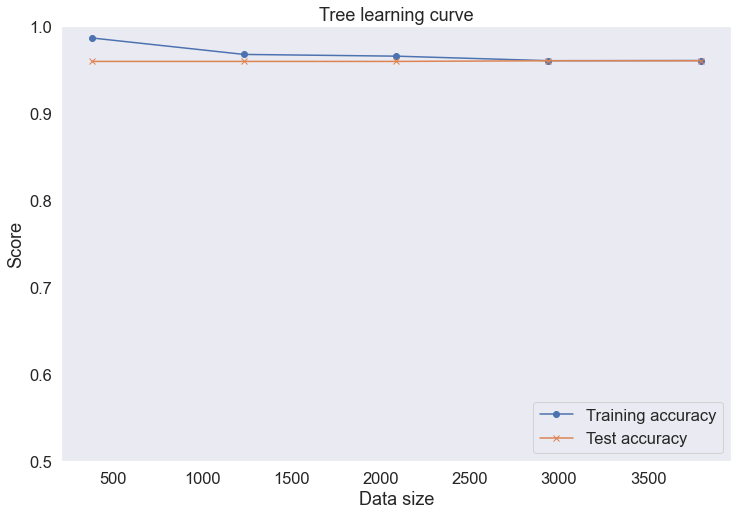

In [179]:
estimator = RandomForestClassifier(max_depth = 8, max_features = 3, random_state=42)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X_train, y_train, cv=30,return_times=True, n_jobs = 4)

plt.figure (figsize = (12,8))
plt.plot(train_sizes,np.mean(train_scores,axis=1), label = 'Training accuracy', marker = 'o')
plt.plot(train_sizes,np.mean(test_scores,axis=1), label = 'Test accuracy', marker = 'x')
plt.ylim ([0.5, 1])
plt.xlabel('Data size')
plt.ylabel('Score')
plt.title('Random Forest Classifier learning curve')
plt.grid()
plt.legend(loc="lower right")

In [186]:
# Calculate the score for Testing Data
score_test = clf.score(X_test, y_test)
score_train = clf.score(X_train, y_train)
print (score_train, score_test)

0.9645950076413653 0.9460285132382892


In [188]:
y_pred_clf = clf.predict(X_test)
con_mat_array = confusion_matrix(y_test, y_pred_clf)
con_mat_array

array([[929,   0],
       [ 53,   0]], dtype=int64)

In [189]:
print(classification_report(y_test, y_pred_clf, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.95      1.00      0.97       929
     class 1       0.00      0.00      0.00        53

    accuracy                           0.95       982
   macro avg       0.47      0.50      0.49       982
weighted avg       0.89      0.95      0.92       982



C:\Users\matta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Notes**: Again, missing all the positives when the training data has not been undersampled nor SMOTEd

### 8.2: Random Forest with Undersampling

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.20, random_state=42) #train test split

In [192]:
grid = GridSearchCV(RandomForestClassifier(random_state=42), forest_params, cv = 15, scoring='accuracy', n_jobs = 5)
grid.fit(X_train, y_train)

C:\Users\matta\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.69736495 0.69393939 0.70606061 0.72108037 0.72411067
 0.71528327 0.71198946 0.71528327 0.71528327 0.71818182 0.71212121
 0.71818182        nan        nan 0.69130435 0.69393939 0.71818182
 0.70606061 0.71515152 0.71198946 0.69710145 0.7002635  0.69433465
 0.68550725 0.69156785 0.68853755        nan        nan 0.71818182
 0.70342556 0.70922266 0.70039526 0.68801054 0.6942029  0.69749671
 0.6884058  0.6884058  0.69156785 0.6826087  0.6826087         nan
        nan 0.70922266 0.72134387 0.68801054 0.69736495 0.6884058
 0.69156785 0.69459816 0.69472991 0.69156785 0.67944664 0.66442688
 0.66758893        nan        nan 0.70039526 0.71818182 0.71501976
 0.70342556 0.6911726  0.71554677 0.69130435 0.69459816 0.70632411
 0.6884058  0.6884058  0.68234519        nan        nan 0.74505929
 0.72411067 0.70909091 0.72147563 0.70632411 0.7034255

GridSearchCV(cv=15, estimator=RandomForestClassifier(random_state=42), n_jobs=5,
             param_grid=[{'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                        14],
                          'max_features': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                           12, 13]}],
             scoring='accuracy')

In [193]:
grid.best_score_

0.7450592885375493

In [194]:
grid.best_params_

{'max_depth': 7, 'max_features': 1}

In [203]:
# Choose a model or models
clf = RandomForestClassifier(max_depth= 5, max_features = 2, random_state=42)

In [204]:
# Fit model
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=2, random_state=42)

In [205]:
# Evaluate model against training set
clf.score(X_train, y_train)

0.8233532934131736

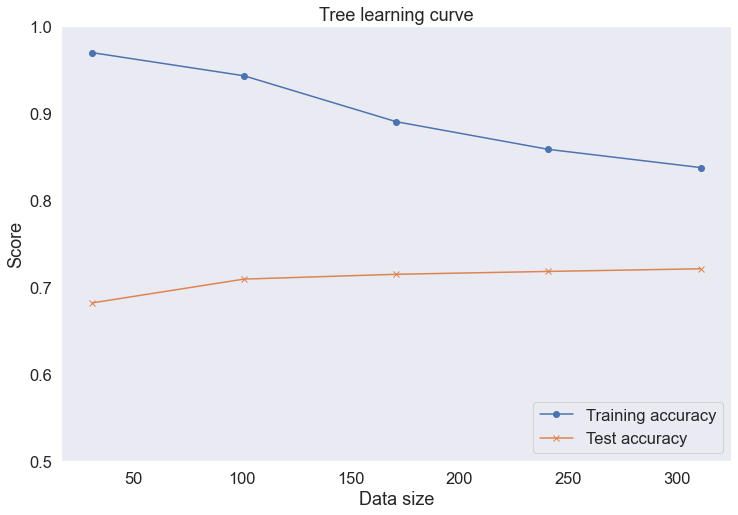

In [206]:
estimator = RandomForestClassifier(max_depth = 5, max_features = 2, random_state=42)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X_train, y_train, cv=15,return_times=True, n_jobs = -1)

plt.figure (figsize = (12,8))
plt.plot(train_sizes,np.mean(train_scores,axis=1), label = 'Training accuracy', marker = 'o')
plt.plot(train_sizes,np.mean(test_scores,axis=1), label = 'Test accuracy', marker = 'x')
plt.ylim ([0.5, 1])
plt.xlabel('Data size')
plt.ylabel('Score')
plt.title('Random Forest Classifier learning curve')
plt.grid()
plt.legend(loc="lower right")

In [207]:
# Calculate the score for Testing Data
score_test = clf.score(X_test, y_test)
score_train = clf.score(X_train, y_train)
print (score_train, score_test)

0.8233532934131736 0.8095238095238095


In [208]:
y_pred_clf = clf.predict(X_test)
con_mat_array = confusion_matrix(y_test, y_pred_clf)
con_mat_array

array([[30, 12],
       [ 4, 38]], dtype=int64)

In [209]:
print(classification_report(y_test, y_pred_clf, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.88      0.71      0.79        42
     class 1       0.76      0.90      0.83        42

    accuracy                           0.81        84
   macro avg       0.82      0.81      0.81        84
weighted avg       0.82      0.81      0.81        84



## 8.3 : Random Forest with SMOTE

In [210]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.20, random_state=42) #train test split

print('Original dataset shape', collections.Counter(y))
print('Resample dataset shape', collections.Counter(y_smote))

Original dataset shape Counter({0: 4699, 1: 209})
Resample dataset shape Counter({1: 4699, 0: 4699})


In [211]:
grid = GridSearchCV(RandomForestClassifier(random_state=42), forest_params, cv = 15, scoring='accuracy', n_jobs = -1)
grid.fit(X_train, y_train)

C:\Users\matta\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.75086772 0.7656297  0.77081693 0.77028466 0.77134708
 0.76961959 0.77015133 0.76935293 0.76975266 0.76988573 0.77015186
 0.76975266        nan        nan 0.75778377 0.77201348 0.77467376
 0.77706923 0.77706685 0.7753383  0.77839805 0.77773325 0.7801266
 0.78691276 0.79156932 0.79329707        nan        nan 0.77667189
 0.78451676 0.78278874 0.78544876 0.78877332 0.78770957 0.79741977
 0.80207659 0.80140966 0.8036726  0.80194405 0.80207818        nan
        nan 0.79342722 0.79462589 0.79781871 0.7994171  0.80539929
 0.81178307 0.8128492  0.81284973 0.8172383  0.81790576 0.82043456
 0.82003483        nan        nan 0.81909859 0.80979078 0.81324761
 0.81657429 0.82362287 0.82375647 0.83266853 0.83666054 0.83878856
 0.84131843 0.84344352 0.84277978        nan        nan 0.83399575
 0.83439549 0.83226906 0.83732084 0.84477155 0.8508894

GridSearchCV(cv=15, estimator=RandomForestClassifier(random_state=42),
             n_jobs=-1,
             param_grid=[{'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                        14],
                          'max_features': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                           12, 13]}],
             scoring='accuracy')

In [212]:
grid.best_score_

0.9220536350936904

In [213]:
grid.best_params_

{'max_depth': 14, 'max_features': 12}

In [227]:
# Choose a model or models
clf = RandomForestClassifier(max_depth= 14, max_features = 4, random_state=42)

In [228]:
# Fit model
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=14, max_features=4, random_state=42)

In [229]:
# Evaluate model against training set
clf.score(X_train, y_train)

0.9678105879223198

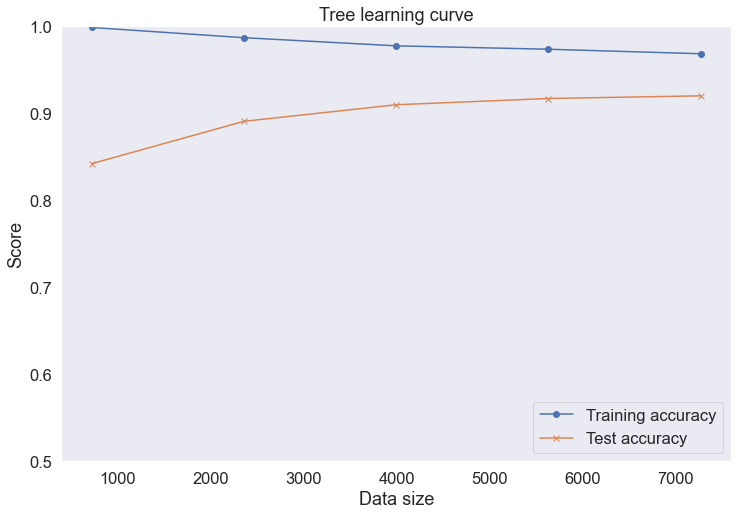

In [230]:
estimator = RandomForestClassifier(max_depth = 14, max_features = 4, random_state=42)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X_train, y_train, cv=30,return_times=True, n_jobs = -1)

plt.figure (figsize = (12,8))
plt.plot(train_sizes,np.mean(train_scores,axis=1), label = 'Training accuracy', marker = 'o')
plt.plot(train_sizes,np.mean(test_scores,axis=1), label = 'Test accuracy', marker = 'x')
plt.ylim ([0.5, 1])
plt.xlabel('Data size')
plt.ylabel('Score')
plt.title('Random Forest Classifier learning curve')
plt.grid()
plt.legend(loc="lower right")

In [231]:
# Calculate the score for Testing Data
score_test = clf.score(X_test, y_test)
score_train = clf.score(X_train, y_train)
print (score_train, score_test)

0.9678105879223198 0.9361702127659575


In [232]:
y_pred_clf = clf.predict(X_test)
con_mat_array = confusion_matrix(y_test, y_pred_clf)
con_mat_array

array([[828,  94],
       [ 26, 932]], dtype=int64)

In [233]:
print(classification_report(y_test, y_pred_clf, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.97      0.90      0.93       922
     class 1       0.91      0.97      0.94       958

    accuracy                           0.94      1880
   macro avg       0.94      0.94      0.94      1880
weighted avg       0.94      0.94      0.94      1880



## 9: More analysis

#### Before undersampling and smote:

- The target column is heavily unbalanced (20:1 ratio) thus, algorithms such as LogReg completely miss the negative results.
- The issue becomes apparent when the confusion matrices show zeros in the negative column. That means the models (both SVM and LogReg) are missing the negative predictions, and just making false positive predictions.
- Need to modify the training data to make models better.

#### After undersampling and smote:

- The models performed better with the undersampling than the SMOTE.
- LogReg performed best when using SMOTE.
- GNB performed best when undersampling

#### Classification scores before modification

| Model | Recall score |   F1 score    | Accuracy |
|:--------------|:-----------:|:----------:|:----------:|
| **Logistic Regression** | 1    | 0   | 0.95 |
| **SVM**      | 1 |    0   | 0.95|
| **GaussianNB**      | 0.51 |    0.25  | 0.84|
| **Random Forest**      | 0 |    0  | 0.95|

#### Classification scores after undersampling

| Model | Recall score |   F1 score    |Accuracy |
|:--------------|:-----------:|:----------:|:----------:|
| **Logistic Regression** | 0.88   |   0.82    |0.81 |
| **SVM**      | 0.98 |    0.87|  0.86|
| **GaussianNB**      | 0.95 |   0.82|  0.80|
| **Random Forest**      |0.93 |    0.84  | 0.82|

#### Classification scores after SMOTE

| Model | Recall score |   F1 score    |Accuracy |
|:--------------|:-----------:|:----------:|:----------:|
| **Logistic Regression** | 0.82   |  0.81  |0.80 |
| **SVM**      | 0.87 |   0.82   |0.81 |
| **GaussianNB**      | 0.96 | 0.77 |0.72 |
| **Random Forest**      | 0.97 |    0.94  | 0.94|

## Conclusion: 

Creating and fitting a model based on SVM, standardised data, specifically chosen features and undersampling, we found that we get an accuracy of 86% (lower than the baseline accuracy (94%) with very high recall (likelihood of predicting strokes) at 0.98 and a very good f1-score at 0.87. <br>

However, using **Random Forest** (14 depth, 4 features) produced the best outcome. Recall = 0.97, F1 score = 0.97, accuracy = 0.94. This makes it the best model.

Although the Random Forest model accuracy is less than the baseline accuracy, the model is good for the following reasons:
 - Very high recall, very good likelihood of predicting stroke (True Positive).
 - A high f1-score, very low likelihood of missing a stroke prediction (False negative).
 - Some false positives, but those can be cleared with further medical examination.
 - The pros outweigh the cons of the model, therefore it is a very good preliminary diagnosis tool.

**Sources**:<br>
https://www.healthdirect.gov.au/stroke - stroke definition<br>
https://www.betterhealth.vic.gov.au/health/conditionsandtreatments/effects-of-stroke - effects of stroke <br>
https://www.kaggle.com/fedesoriano/stroke-prediction-dataset - Dataset<br>
https://stackoverflow.com/questions/55104819/display-count-on-top-of-seaborn-barplot - adding labels to bar plot<br>
https://www.statology.org/pandas-drop-rows-with-value/ - drop specific rows<br>
https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/ - precision, recall and f1